# Import

In [1]:
!pip install attacut pythainlp

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.7 MB/s eta 0:00:00m eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=122f7386634b3de6cd79e702805dd9a14b5227c36b8ae848396a9857958b78a7
  Stored in directory: /home/ss/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=c4600547d20e02f821c4f16c2d0fe2d9df13e001bbe8acddd9b3f123bdf97d53
  Stored in directory: /home/ss/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built docopt fire


In [2]:
import pandas as pd
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from sklearn.model_selection import train_test_split     ## import train & test splitting library from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.naive_bayes import CategoricalNB   ,BernoulliNB , MultinomialNB  ## Bernoulli Naive Bayes
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score
import joblib
import re
import numpy as np

# Read

In [3]:
df = pd.read_json("./thai_sentiment_dataset.json")
df = df.drop_duplicates()

In [4]:
df.sample(5)

,story,sentiment
5142,Post Views: 1\n\n \n\n\nมุกดาหาร กฐินน้ำบูชาพ...,positive
10211,เรือนชฎานาง ทางสถานีโทรทัศน์ช่อง8 อีพี12 มาในโ...,negative
24886,บริษัท เซ็นทรัล เรสตอรองส์ กรุ๊ป จำกัด (ซีอาร์...,neutral
14549,“แม่นายเบลล่า” กอดๆ แม่มะลิหลัง “จอร์จ ฟอลคอน”...,negative
4207,กรุงเทพฯ 7 พ.ย. –ผู้ช่วย สส. ปูอัด ตัดโลโก้พรร...,positive


# ดูอัตราส่วน label
ค่อนข้างเท่ากันจึงไม่ downsample

<Axes: xlabel='sentiment'>

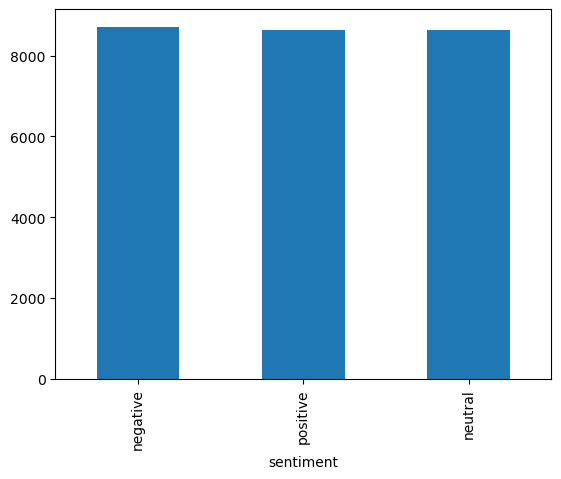

In [5]:
df['sentiment'].value_counts().plot.bar()

# Cleaning
remove everything else except word with length > 1

In [6]:

stopwords = list(thai_stopwords())
print(len(stopwords))
def text_process(text):                                          ###  split word and text preprocessing
    final = re.sub(r'[^a-zA-Z\sก-๛]', '', text, flags=re.UNICODE)
    final = "".join(u for u in final if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    final = word_tokenize(final, engine="newmm")
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split() if word.lower() not in stopwords and len(word) > 1)
    return final.lower()

1030


In [7]:
df['text_tokens'] = df['story'].apply(text_process)
df

,story,sentiment,text_tokens
0,นายสุริยะจึงรุ่งเรืองกิจ รัฐมนตรีว่าการกระทรวง...,positive,สุริยะ รุ่งเรือง กิจ รัฐมนตรี ว่าการ กระทรวงคม...
1,"สวยงามยิ่งนัก กับเพชรเม็ดงามที่หายากยิ่ง ""บลูไ...",positive,สวยงาม เพชร เม็ด งาม หา บลู ได มอนด์ พย สำนักง...
2,"โดยระหว่างวันดัชนีทำจุดสูงสุดที่ 1,417.16 จุด ...",positive,ดัชนี ทำ จุดสูงสุด จุด ทำ จุด ต่ำสุด จุด อันดั...
3,## ประเทศไทยนำเข้าปุ๋ยปีละกว่าแสนล้านบาท ซึ่งห...,positive,ประเทศ ไทย นำเข้า ปุ๋ย ปี แสน ล้าน บาท ผลิต แม...
4,"""เจเอเอส แอสเซ็ท (J)"" โชว์กำไร Q3/66 ทะยาน 617...",positive,เจ เอ เอส แอ เซ็ท โชว์ กำไร ทะยาน โครง การพัฒน...
...,...,...,...
26995,แชร์ :\n\n \n \n \n \n\n\nคุณวิภาวรรณ มหาด...,neutral,แชร์ วิภา วรรณ มหา ดำ รงค์ กุล กรรมการผู้จัดกา...
26996,นายธนวัฒน์ กิตติสุวรรณ ผู้ช่วยผู้จัดการใหญ่ ผู...,neutral,ธน วัฒน์ กิตติ สุวรรณ ผู้ช่วย ผู้จัดการ ผู้บริ...
26997,Advertisement\n\n \n\n\nมติ 'ก้าวไกล' ขับ 'ไช...,neutral,advertisement มติ ก้าวไกล ขับ ไช ยาม วาน พ้น พ...
26998,วันที่ 7 พฤศจิกายน 2566 เวลา 09.00 น. นายไพโร...,neutral,วันที่ พฤศจิกายน เวลา ไพโรจน์ โชติก เสถียร ปลั...


# Extract feature by countvectorizer

In [8]:
count_vector = CountVectorizer(token_pattern="[\S]+")
#count_vector = TfidfVectorizer(token_pattern="[\S]+",smooth_idf=True,use_idf=True)

Y = df['sentiment']
X = df['text_tokens']
X = count_vector.fit_transform(X)   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state=42)
print("Vocab size " ,len(count_vector.vocabulary_))

Vocab size  65786


In [9]:
vocab = list(count_vector.vocabulary_.items())      # For furthur inspection in jupyter
print(len(count_vector.vocabulary_))

65786


# Naive bay model test

In [10]:
clf = MultinomialNB()
clf.fit(X_train, Y_train)
acc = clf.score(X_test,Y_test)
print("Accuracy on test : ",acc)

Accuracy on test :  0.6319938473370506


# LogisticRegression model test

In [11]:
softmax_regression_model = LogisticRegression(multi_class='multinomial',max_iter=1000000,n_jobs=4)
softmax_regression_model.fit(X_train, Y_train)
acc2 = softmax_regression_model.score(X_test,Y_test)
print("Accuracy on test : ",acc2)

Accuracy on test :  0.7375504710632571


# Hyper parameter tuning on RandomForestClassifier

In [12]:
# max_depth=125, n_estimators=200, n_jobs=4)
param_grid = {
    #'n_estimators':list(range(180,240,4)), #[50,100,150,200,225,250],
    #'max_depth':list(range(100,150,3)), # [50, 75, 100,112, 125, 150, 175,200],
    #'max_features': ["sqrt",None]
    # We already know best param
    
    'n_estimators': [115],
    'max_depth': [208],
    'max_features': ['sqrt']
}

# Initialize the RandomForestClassifier
forest_model = RandomForestClassifier(random_state=1, n_jobs=-1)

# Initialize RandomizedSearchCV with the custom scorer
# This already do cross validation on given data!
tuner = HalvingGridSearchCV(estimator=forest_model, param_grid=param_grid, verbose=1,n_jobs=-1)

# Fit the tuner on the training data
tuner.fit(X_train, Y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 20800
max_resources_: 20800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 20800
Fitting 5 folds for each of 1 candidates, totalling 5 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                    n_jobs=-1,
                    param_grid={'max_depth': [208], 'max_features': ['sqrt'],
                                'n_estimators': [115]},
                    verbose=1)

In [13]:
# Results
print("Best parameters:", tuner.best_params_)
print("Best score on val data:", tuner.best_score_)
cv_result = pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")
cv_result

Best parameters: {'max_depth': 208, 'max_features': 'sqrt', 'n_estimators': 115}
Best score on val data: 0.7399038461538462


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,20800,519.191577,11.925353,1.383016,0.447016,208,sqrt,115,"{'max_depth': 208, 'max_features': 'sqrt', 'n_...",...,0.739904,0.007098,1,0.992548,0.992188,0.992788,0.992428,0.992608,0.992512,0.0002


# Create model from tuned parameter

In [14]:
final_model = RandomForestClassifier(n_jobs=4, max_depth=tuner.best_params_["max_depth"], max_features=tuner.best_params_["max_features"], n_estimators=tuner.best_params_["n_estimators"])
final_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=208, n_estimators=115, n_jobs=4)

# Accuracy measure

In [15]:
y_pred = final_model.predict(X_test)
f1 = f1_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
print("f1",f1,"recall",recall)
# Confusion matrix and its label


f1 0.76233544475395 recall 0.7629402891561353


# Train with entire dataset

In [16]:
final_model.fit(X,Y)

RandomForestClassifier(max_depth=208, n_estimators=115, n_jobs=4)

## Save and wait for actual test data

In [17]:
joblib.dump(final_model, "./random_forest.joblib",compress=3)

['./random_forest.joblib']

# Predict on actual test data set

In [18]:
df_test = pd.read_json("./thai_sentiment_dataset_test.json")

df_test['text_tokens'] = df_test['story'].apply(text_process)

Y_TEST = df['sentiment']
X_TEST = count_vector.transform( df['text_tokens'] )
PREDICT = final_model.predict(X_TEST)

f1 = f1_score(Y_TEST, PREDICT, average='macro')
recall = recall_score(Y_TEST, PREDICT, average='macro')
print("f1",f1,"recall",recall)

f1 0.9904211575568006 recall 0.9904183740625326
